In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import umap 
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
pip install torch

  Using cached torch-2.10.0-cp312-cp312-win_amd64.whl.metadata (31 kB)
Using cached torch-2.10.0-cp312-cp312-win_amd64.whl (113.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch-geometric

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

Classes originales : [0 4]
Classes encodées : {0, 1}
Début de l'entraînement...
Epoch 000 | Train Acc: 0.74 | Test Acc: 0.78
Epoch 100 | Train Acc: 0.78 | Test Acc: 0.79
Epoch 200 | Train Acc: 0.76 | Test Acc: 0.79
Epoch 300 | Train Acc: 0.77 | Test Acc: 0.82
Epoch 400 | Train Acc: 0.77 | Test Acc: 0.82
Epoch 500 | Train Acc: 0.77 | Test Acc: 0.82
Epoch 600 | Train Acc: 0.77 | Test Acc: 0.82
Epoch 700 | Train Acc: 0.77 | Test Acc: 0.82
Epoch 800 | Train Acc: 0.77 | Test Acc: 0.81
Epoch 900 | Train Acc: 0.77 | Test Acc: 0.82
Epoch 1000 | Train Acc: 0.77 | Test Acc: 0.82


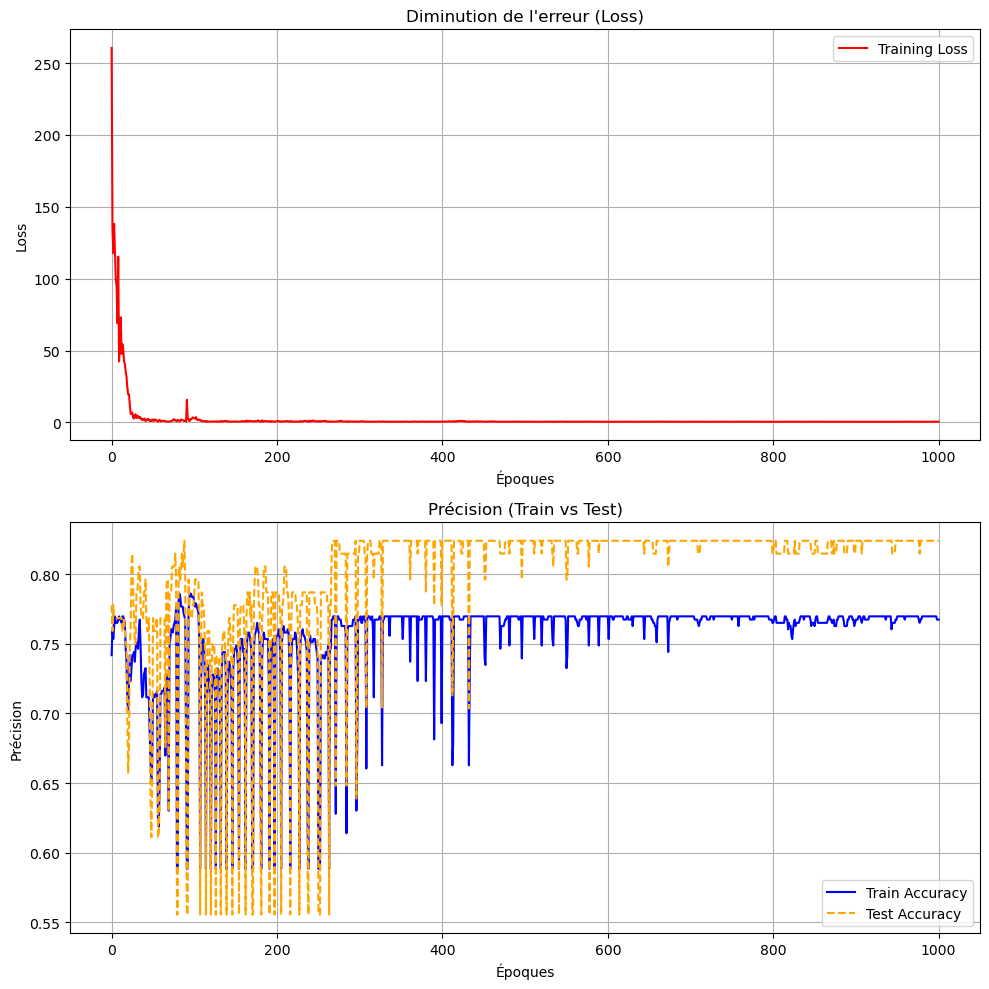

In [26]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder  # <--- AJOUT IMPORTANT

# --- 1. CHARGEMENT (identique) ---
edges_file = 'graphe_complet_final.csv'
nodes_file = 'NODES_climatoscope_graph_2022-07-01_2022-10-30_th=3.0_flc=0_world_2185-pro-anti_Louvaindic_testtop_tableusers.csv'

df_edges = pd.read_csv(edges_file)
df_nodes = pd.read_csv(nodes_file)

# --- 2. NETTOYAGE (identique) ---
node_ids_in_edges = set(df_edges['user_id']).union(set(df_edges['original_author']))
node_ids_in_nodes = set(df_nodes['Id'])
common_ids = list(node_ids_in_edges.intersection(node_ids_in_nodes))

df_nodes_filtered = df_nodes[df_nodes['Id'].isin(common_ids)].sort_values('Id').reset_index(drop=True)
valid_ids = set(df_nodes_filtered['Id'])
df_edges_filtered = df_edges[
    df_edges['user_id'].isin(valid_ids) & 
    df_edges['original_author'].isin(valid_ids)
].copy()

id_to_idx = {id_val: i for i, id_val in enumerate(df_nodes_filtered['Id'])}

# --- 3. CONSTRUCTION (MODIFIÉ) ---

# A. Features
feature_cols = ['nb_retweets', 'nb_retweeted', 'pageranks'] 
df_nodes_filtered[feature_cols] = df_nodes_filtered[feature_cols].fillna(0)
x = torch.tensor(df_nodes_filtered[feature_cols].values, dtype=torch.float)

# B. Labels (CORRECTION ICI)
# On transforme les classes {0, 4} en {0, 1}
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_nodes_filtered['modularity_class'].values)
y = torch.tensor(y_encoded, dtype=torch.long)

# On garde le nombre de classes pour plus tard
num_classes = len(encoder.classes_)
print(f"Classes originales : {encoder.classes_}")
print(f"Classes encodées : {set(y_encoded)}")

# C. Liens
source = df_edges_filtered['user_id'].map(id_to_idx).values
target = df_edges_filtered['original_author'].map(id_to_idx).values
# Correction du warning de lenteur (numpy -> tensor)
edge_index = torch.tensor([source, target], dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

# Masques
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
indices = torch.randperm(data.num_nodes)
split = int(0.8 * data.num_nodes)
data.train_mask[indices[:split]] = True
data.test_mask[indices[split:]] = True

# --- 4. MODÈLE & ENTRAÎNEMENT ---
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Utilisation du num_classes calculé proprement plus haut
model = GCN(num_features=data.num_features, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# --- 4. ENTRAÎNEMENT AVEC HISTORIQUE ---
train_losses = []
train_accs = []
test_accs = []

print("Début de l'entraînement...")
for epoch in range(1001):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    
    # Calcul de l'erreur
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Stockage de l'erreur
    train_losses.append(loss.item())
    
    # Évaluation (Sans apprentissage)
    model.eval()
    with torch.no_grad():
        pred = model(data).argmax(dim=1)
        
        # Précision Train
        acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
        train_accs.append(acc_train)
        
        # Précision Test
        acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        test_accs.append(acc_test)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch:03d} | Train Acc: {acc_train:.2f} | Test Acc: {acc_test:.2f}')

# --- 5. AFFICHAGE (MODIFIÉ : L'UN SOUS L'AUTRE) ---
plt.figure(figsize=(10, 10)) # Figure plus haute

# Graphe 1 (Haut) : L'erreur
plt.subplot(2, 1, 1) # 2 lignes, 1 colonne, position 1
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Diminution de l\'erreur (Loss)')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Graphe 2 (Bas) : La précision
plt.subplot(2, 1, 2) # 2 lignes, 1 colonne, position 2
plt.plot(train_accs, label='Train Accuracy', color='blue')
plt.plot(test_accs, label='Test Accuracy', color='orange', linestyle='--')
plt.title('Précision (Train vs Test)')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.grid(True)
plt.legend()

plt.tight_layout() # Ajuste automatiquement les espaces
plt.show()